# Viome Data Challenge

The main aim of this report is to understand how to approach a simple problem in the healthcare domain. Two common problems are generally in this domain  are - Class Imbalance and High Dimensionality. In this problem, we observe the latter problem. A few approaches to this problem have been looked at and evaluated in this challenge. This report has been organized in six sections as mentioned below.

### Index

1. Basic Data Analysis
2. Baseline Models
    - Baseline Model 1 - Logistic Regression
    - Baseline Model 2 - Random Forest Classifier
3. Feature Selection
4. Model Selection and Model Evaluation
5. Concluding Remarks
6. Future Work

### Basic Data Analysis

In [95]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import f_classif
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [46]:
#loading .csv files into respective dataframes
labels = pd.read_csv('labels.csv')
user_ids = pd.read_csv('user_ids.csv')
data = pd.read_csv('data.csv')
df = pd.read_csv('data_labels_user_id.csv')

**Note** : The combined dataset was present and used for this work. There was no need to combine the files.

In [47]:
#storing the sum of each row in a new column named Total
columns =df.columns.tolist()
columns.remove('user_id')
columns.remove('labels')
df['Total'] = df[columns].sum(axis=1)

In [48]:
#calculating proportions
new_df = df[columns].div(df['Total'], axis=0)
X = new_df.values[:,:]
y = df['labels'].values

In [49]:
# Look at data
X,y

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([1, 1, 0, ..., 1, 1, 1]))

In [50]:
# Changing the dataframe
new_df['user_id'] = df['user_id']
new_df['labels'] = df['labels']
#reordering the columns
col = df.columns.tolist()
col.remove('Total')
new_df = new_df[col]
col.remove('user_id')

In [51]:
# Top 5 rows of data
new_df.head()

,user_id,0,1,2,3,4,5,6,7,8,...,991,992,993,994,995,996,997,998,999,labels
0,546fd0a2-3ed1-11e9-af14-060058a8e501,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
1,54921d88-3ed1-11e9-857c-060058a8e501,0.0,0.0,0.0,0.0,0.004858,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
2,547090fa-3ed1-11e9-b20e-060058a8e501,0.0,0.0,0.0,0.0,0.041481,0.0,0.016572,0.0,0.0,...,0.0,0.00058,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,54921180-3ed1-11e9-8bb6-060058a8e501,0.0,0.0,0.0,0.0,0.020696,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000004,0.0,0.0,1
4,548eff9a-3ed1-11e9-b691-060058a8e501,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1


In [52]:
sum(new_df['user_id'].value_counts()==2)

4775

In [53]:
sum(new_df['user_id'].value_counts()==1)

45225

The data has 4775 user_ids which have two samples and 45225 samples which have a single sample.

In [54]:
# understanding statistics of new_df
new_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,labels
count,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,5.477500e+04,54775.000000,...,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000,54775.000000
mean,0.000002,0.001457,0.004885,0.000202,0.003500,0.000032,0.000682,0.000676,9.878475e-07,0.001263,...,0.000129,0.002517,0.000142,0.000191,0.001064,0.000221,0.001594,0.000035,0.000034,0.556860
std,0.000209,0.012198,0.021547,0.003768,0.018637,0.001613,0.007898,0.007845,1.347670e-04,0.010681,...,0.003168,0.016144,0.004014,0.004157,0.009678,0.004621,0.010368,0.001642,0.001690,0.496761
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000001,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.037977,0.443544,0.486989,0.225908,0.428083,0.196097,0.436671,0.356488,2.343660e-02,0.441560,...,0.200887,0.520523,0.288720,0.277607,0.373139,0.350776,0.272583,0.223409,0.187166,1.000000


It can be seen above that our data does not contain any missing values. However, our data does contain many features which have a very high difference between the mean and maximum. Hence, min max scaling cannot be used to scale the data as it is very sensitive to outliers. It can be seen that the data has 1000 features (high dimensionality) and is very sparse. This type of data (bacterial species, genes, biomarkers etc.) is prevalant in the healthcare domain.

##### Check for balanced classes 

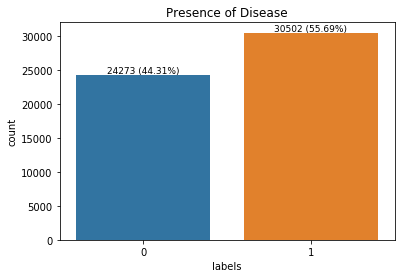

In [55]:
#plotting the number of 1's and 0's in the labels column
fig,ax = plt.subplots()
ax = sns.countplot(x='labels', data=new_df)
for i in ax.patches:
    height = i.get_height()
    percent = height*100/float(len(df))
    ax.text(i.get_x()+i.get_width()/2,height+0.5,"%d (%.2f" % (height,percent)+"%)", ha = "center", va = "bottom", fontsize = 9)
    ax.set_title("Presence of Disease")

Before solving the classification problem it is important to check for balanaced classes. The above figure tells us that we have a balanced dataset i.e. approximately the same number of 1 and 0 labels.

## Baseline Models

To get a baseline estimate, I will train basic learning models to understand how well the data works with various models. As this is work on baseline, the models have will be trained on all the features.

The data has been standardized because all the features have different ranges as can be seen when using the describe method.
Also, the testing data has been standardized using the mean and variance of the training data. This is done because the testing data represents unseen data similar to what happens in the real world.

In [56]:
#Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)

scaled_X = StandardScaler().fit(X_train)
X_train_std = scaled_X.transform(X_train)
X_test_std = scaled_X.transform(X_test)

##### Baseline Model 1 - Logistic Regression 

In [87]:
#Logistic Regression
logistic_regression = LogisticRegression(random_state = 0, solver = 'sag').fit(X_train_std,y_train)
logistic_regression.coef_

array([[-7.90103186e-02,  1.47478174e-01, -2.23213488e-02,
         1.16161845e-01, -2.15909210e-01,  1.14923521e-01,
         5.49841514e-02,  6.04366269e-02, -4.81460089e-02,
        -7.88326637e-02, -4.68423711e-02,  7.76264884e-02,
        -3.58961026e-02, -6.36329273e-03,  1.67873561e-02,
         2.06050806e-02,  1.28789075e-01,  1.13450253e-02,
         4.54163173e-02,  4.28897890e-02, -5.97798697e-02,
        -1.30144185e-01,  4.31731823e-02,  2.80288367e-02,
         5.71322263e-02,  1.51202430e-03, -4.86719319e-02,
         4.33063165e-03,  5.35432986e-02, -2.98053466e-02,
        -3.24876362e-02, -1.12301524e-01,  1.46037920e-01,
        -7.28466851e-02, -7.68708478e-02,  5.79657549e-02,
        -4.26507836e-02, -1.33991991e-02,  1.50791089e-01,
         5.17469931e-02,  1.77229563e-01,  1.67806946e-02,
        -7.89625449e-02,  2.29545725e-02,  2.79017342e-02,
        -1.32704906e-02, -5.52232878e-02,  5.12298397e-02,
        -7.80935469e-02, -1.12733353e-01,  5.71907048e-0

In [89]:
y_pred = logistic_regression.predict(X_test_std)
print("Training accuracy score :", accuracy_score(y_train,logistic_regression.predict(X_train_std)))
print("Testing accuracy score :", accuracy_score(y_test,y_pred))

Training accuracy score : 0.7797124600638977
Testing accuracy score : 0.7740757644910999


###### Observations on baseline model 1

When analyzing the coefficients for each of the features using Logistic Regression, we see that all the features have a non zero coefficient but some very large and some small. Since the number of features are really large, there is always a possibility that a few features might be more important and a few might be just be noise. Hence, feature selection is an important step in building any predictive model. 

##### Baseline Model 2 - Random Forest Classifer

In [14]:
#Random Forests
random_forests = RandomForestClassifier(n_estimators = 300).fit(X_train_std,y_train)
y_pred = random_forests.predict(X_test_std)
print("Training accuracy score :", accuracy_score(y_train, random_forests.predict(X_train_std)))
print("Testing accuracy score :", accuracy_score(y_test,y_pred))

Training accuracy score : 1.0
Testing accuracy score : 0.775627567320858


In [15]:
#finding the optimal depth d
acc_train =[]
acc_test = []
for i in range(5,25,2):
    random_forests = RandomForestClassifier(n_estimators = 300, max_depth =i).fit(X_train_std,y_train)
    y_pred = random_forests.predict(X_test_std)
    acc_train.append(accuracy_score(y_train,random_forests.predict(X_train_std)))
    acc_test.append(accuracy_score(y_test,y_pred))

Text(0.5,1,'Random Forest Feature Selection')

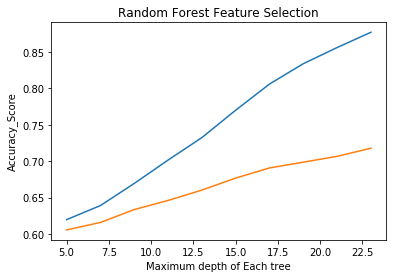

In [16]:
plt.plot(range(5,25,2),acc_train,label='Training Accuracy')
plt.plot(range(5,25,2),acc_test,label='Testing Accuracy')
plt.xlabel('Maximum depth of Each tree')
plt.ylabel('Accuracy_Score')
plt.legend(loc='lower right')
plt.title('Finding depth d')

In [17]:
random_forests = RandomForestClassifier(n_estimators = 300, max_depth =20).fit(X_train_std,y_train)
y_pred = random_forests.predict(X_test_std)
print("Training accuracy score :", accuracy_score(y_train,random_forests.predict(X_train_std)))
print("Testing accuracy score :", accuracy_score(y_test,y_pred))

Training accuracy score : 0.842743039707896
Testing accuracy score : 0.7021451392058421


###### Observations on baseline model 2

###### With no max depth

The Random Forest Classifier correctly predicts 77% of the testing data and 100% of the training data.This is because of the fact that the max depth parameter in the random forests classifier was set to default which means that it builds a tree until the end. In other words, we can say that the model overfits the training data. At this step, the model is trained without tuning any parameters.

###### With max depth = 20

To try and avoid overfitting, max depth is set to 20 and observations are made. The maximum depth d = 20 is chosen by searching through all possible depth sizes ranging from 5 to 25 in steps of size 2 and finding the corresponding training and testing depth. It can be seen that the training accuracy has changed from 100% to 84% and the testing accuracy has changed from 77.63% to 70%. Intuitively, it feels that the model with no max depth is better than the model with max depth set to 20. However, the accuracy score for the training and testing data are close to each other for this model as compared to the other model because it overcomes an important problem in the machine learning domain, overfitting. This in turn improves the generalization of the model.

## Feature Selection

Since I have high dimensionality data (1000 features), it is important to only consider the important features (Curse of dimensionality). I have first reduced the dimensionality by using f_classif which uses the one way ANOVA F-score which tests the null hypothesis that the two groups have the same mean on each of the features. It computes the F score and corresponding p-value for each of the features. However, since we are performing the test on each of the features, we will have a number of false positives which we will want to reduce. Hence, i have reduced the false discovery rate by using SelectFdr which uses the Benjamini Hochberg procedure. 

#### Method 1 - One way ANOVA 

In [57]:
X_train_std.shape

(43820, 1000)

In [58]:
#feature selection using one way ANOVA F test and FDR
fdr = SelectFdr(f_classif, alpha=0.05)
X_train_std = fdr.fit_transform(X_train_std,y_train)
X_test_std = fdr.transform(X_test_std)
feature_selected = [ col[i] for i in fdr.get_support(indices=True)]

In [59]:
X_train_std.shape

(43820, 419)

As seen above, the dimensionality of the dataset has reduced from 1000 to 419. However, it is still quite large and we need to further reduce the dimensionality.I have tried to reduce the dimensionality by using Principal Component Analysis (PCA). 

#### Method 2 - Principal Component Analysis

Text(0,0.5,'Variance (%)')

<Figure size 432x288 with 0 Axes>

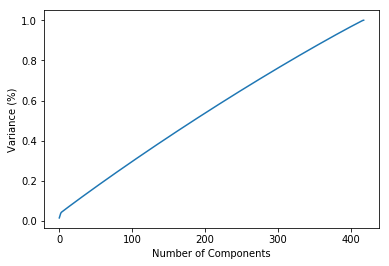

In [60]:
#using PCA to find important features
pca=PCA().fit(X_train_std)
plt.figure()
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 

As seen above, Principal Component Analysis (PCA) did not help us reduce the dimensionality of our dataset. The graph tells us that almost every component contributes equally to the variance of the dataset.

So, I have now used the Random Forest Classifier to find the most important features of the dataset.

#### Method 3 - Random Forests Classifier

In [61]:
#Random Forest Feature Selection
random_forest = RandomForestClassifier(n_estimators = 300,max_depth = 20)
random_forest.fit(X_train_std, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
#the importanceof every feature
random_forest.feature_importances_
for feature in zip(col, random_forest.feature_importances_):
    print(feature)

('0', 0.0022234984115041406)
('1', 0.0028715973668420893)
('2', 0.004292745954335973)
('3', 0.000818293670980406)
('4', 0.011712188146933932)
('5', 0.001447567816644755)
('6', 0.005548025871282907)
('7', 0.0006173246168091226)
('8', 0.001560211100589264)
('9', 0.0011701867908032008)
('10', 0.0014173573971190494)
('11', 0.00260976190637167)
('12', 0.000781503890723054)
('13', 0.0007126126865975685)
('14', 0.00026094992782623285)
('15', 0.0008765256551855296)
('16', 0.0010140922776689521)
('17', 0.00142091448324174)
('18', 0.0009798931432287257)
('19', 0.0008956293706634522)
('20', 0.0008334838695680063)
('21', 0.002623534707918313)
('22', 9.923854325399888e-05)
('23', 0.0014951598728325628)
('24', 0.0004955971328056957)
('25', 0.001749976826106534)
('26', 0.0003331267909284881)
('27', 0.002137332635322332)
('28', 0.000972789003847133)
('29', 0.00030029228304211537)
('30', 0.004680443688572037)
('31', 0.001724203139952544)
('32', 0.0054335662188906035)
('33', 0.002687368072802088)
('34',

In [63]:
#function to select top k important features
def selectKImportance(model, X, k=5):
     return X[:,model.feature_importances_.argsort()[::-1][:k]]

In [64]:
#finding the appropiate number of features
acc_test=[]
acc_train=[]
for i in range(10,300,30):
    X_important_train = selectKImportance(random_forest,X_train_std,i)
    X_important_test = selectKImportance(random_forest,X_test_std,i)
    important = RandomForestClassifier(n_estimators=300,max_depth=20)
    important.fit(X_important_train, y_train)
    acc_test.append(accuracy_score(y_test,important.predict(X_important_test)))
    acc_train.append(accuracy_score(y_train,important.predict(X_important_train)))

Text(0.5,1,'Random Forest Feature Selection')

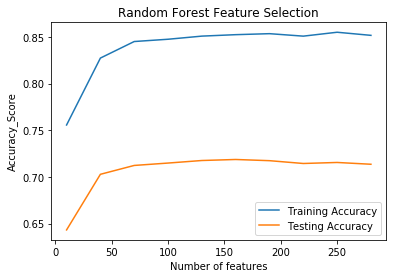

In [65]:
#plotting the graph
plt.plot(range(10,300,30),acc_train,label='Training Accuracy')
plt.plot(range(10,300,30),acc_test,label='Testing Accuracy')
plt.xlabel('Number of features')
plt.ylabel('Accuracy_Score')
plt.legend(loc='lower right')
plt.title('Random Forest Feature Selection')

The graph above tells us that once the number of features crosses around 100, the increase in accuracy per feature added is very less i.e. it is trade off between computational burden and accuracy. Hence, I have decided to take the top 100 features for my predictive model.

**Note**: The accuracy score gives us a basic intuition of how well the model is doing. This cannot be used as a comprehensive tool for evaluating the model. Other good model evaluation techniques for classification problems are F1-score, Confusion Matrix, ROC and AUC.

In [66]:
#top 100 selected features
selected_features = [col[i] for i in random_forest.feature_importances_.argsort()[::-1][:100]]
print(selected_features)

['378', '321', '360', '185', '397', '351', '161', '54', '58', '207', '323', '4', '371', '340', '206', '191', '280', '201', '400', '222', '121', '237', '177', '204', '354', '91', '90', '60', '114', '333', '119', '243', '389', '6', '32', '96', '192', '117', '244', '301', '375', '318', '105', '391', '30', '144', '278', '219', '401', '157', '170', '118', '216', '2', '37', '233', '115', '252', '223', '411', '57', '159', '51', '341', '324', '173', '320', '146', '268', '248', '379', '180', '211', '287', '164', '349', '143', '66', '194', '239', '77', '353', '130', '102', '258', '370', '240', '71', '396', '335', '309', '1', '316', '40', '67', '74', '213', '355', '45', '152']


## Model Selection and Evaluation

Having selected the important features, the next step is to experiment with different models. The first classifier I tried was Random Forests Classifier. Earlier we had a baseline estimate of our Random Forests Classifier using all 1000 features in our dataset. Having reduced our feature space to only a 100 features, it now becomes very important to tune the hyperparameters as well when we build our model. For hyperparameter tuning, I have used GridSearchCV which searches through all possible combinations passed to it in the parameters dictionary and it finds the best possible combination. Though, it is computationally very expensive, it provides very accurate results as it generalizes better with the problem at hand. 

#### Model 1 - Random Forests Classifier

In [67]:
#Reducing dimensionality of test train data to 100
X_important_train = selectKImportance(random_forest,X_train_std,100)
X_important_test = selectKImportance(random_forest,X_test_std,100)

**Note**: GridSearchCV takes a very very long time to run because it iterates through all possible parameter combinations and also uses cross validation.

In [29]:
#Hyperparameter tuning using GridSearch CV
random_forest = RandomForestClassifier(random_state = 8)
parameters = {'n_estimators':[100,200,300,400],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [18,20,22],
              'criterion' :['gini','entropy']}
classifier = GridSearchCV(random_forest,parameters,cv = 5)
classifier.fit(X_important_train,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [18, 20, 22], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
classifier.best_params_

{'criterion': 'gini',
 'max_depth': 22,
 'max_features': 'auto',
 'n_estimators': 400}

Having found the best parameters, the next step is to train the Random Forest Classifier using these paramters and then evaluate it. To evaluate the model I am implementing a Stratified K-fold cross validation technique. As a starting point I selected k to be 5. For each fold, I have calculated the AUC (area under the ROC curve), Accuracy Score (percentage of correct predictions) and the F-1 Score (harmonic mean of precision and recall) as evaluation metrics to better understand how the models build are performing.

#### K-Fold Cross Validation

In [75]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 5, random_state = 420)
auc_scores = []
accuracy_scores = []
f1_scores = []

fold = 1
for train_idx, valid_idx in cv.split(X_important_train, y_train):
    xtrain, xvalid = X_important_train[train_idx], X_important_train[valid_idx]
    ytrain, yvalid = y_train[train_idx], y_train[valid_idx]

    model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=400 , max_depth = 22, criterion='gini')
    model.fit(xtrain, ytrain)
    
    valid_preds=model.predict(xvalid)
    probs = model.predict_proba(xvalid)
    pred = probs[:,1]
    
    aucs = roc_auc_score(yvalid, pred)
    accuracy = accuracy_score(yvalid,valid_preds)
    f1 = f1_score(yvalid,valid_preds)
    
    auc_scores.append(aucs)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    print("Fold = {}. AUC = {}. Accuracy = {}. F-1 Score = {}.".format(fold, aucs,accuracy,f1))

    fold += 1
print(' ')
print("Mean AUC Score: {}. Std Dev: {}".format(np.mean(auc_scores), np.std(auc_scores)))
print("Mean Accuracy Score: {}. Std Dev: {}".format(np.mean(accuracy_scores), np.std(accuracy_scores)))
print("Mean F-1 Score: {}. Std Dev: {}".format(np.mean(f1_scores), np.std(f1_scores)))


Fold = 1. AUC = 0.7988513360517999. Accuracy = 0.7123787792355961. F-1 Score = 0.7740836992562058.
Fold = 2. AUC = 0.7955352845816763. Accuracy = 0.7115472387037882. F-1 Score = 0.773720014321518.
Fold = 3. AUC = 0.7858734232123408. Accuracy = 0.7013920584208124. F-1 Score = 0.7639577884008298.
Fold = 4. AUC = 0.7926147181623986. Accuracy = 0.7074395253308992. F-1 Score = 0.7679638009049774.
Fold = 5. AUC = 0.7859853299159085. Accuracy = 0.7083190688120506. F-1 Score = 0.7694805194805195.
 
Mean AUC Score: 0.7917720183848249. Std Dev: 0.005162717161700315
Mean Accuracy Score: 0.7082153341006293. Std Dev: 0.003888588299544058
Mean F-1 Score: 0.7698411644728101. Std Dev: 0.0037765923877957396


As mentioned earlier, we see that accuracy is not the best method to evaluate how well a model performs. Better methods to evaluate models build (for this type of problem) are AUC and F-1 Score. This result is expected and inline with my understanding. 

In [69]:
#Performace of testing set
model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators=400 , max_depth = 22, criterion='gini')
model.fit(X_important_train, y_train)
y_pred = model.predict(X_important_test)
probs = model.predict_proba(X_important_test)
pred = probs[:,1]
print("AUC_Score : {}.".format(roc_auc_score(y_test,pred)))
print("Accuracy Score : {}.".format(accuracy_score(y_test,y_pred)))
print("F-1 Score : {}.".format(f1_score(y_test,y_pred)))

AUC_Score : 0.8053409431706495.
Accuracy Score : 0.7183021451392059.
F-1 Score : 0.7773770018756313.


The f1 score gives us the harmonic mean of Precision and Recall. Precison is the ratio of true positives to all predicted positive and recall is the ratio of true positives to all positives. An f1 score captures more detail than accuracy (as it is in a way representing the information from the confusion matrix) and therefore, 0.77 tells us that our model does well. 

#### Confusion matrix for the classifier model

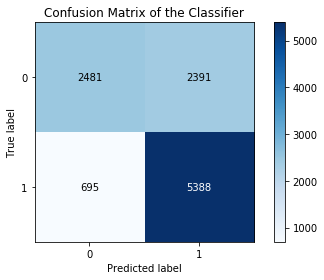

In [76]:
#printing the confusion matrix
labels = ['0','1']
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title="Confusion Matrix of the Classifier",
           ylabel='True label',
           xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


The confusion matrix gives us a very good understanding of any classification model. It gives us the number of true positives (5388), true negatives (2481) , false positives (2391) and false negatives (695) for our binary classification task. An important point to note is that there are very few false negatives as compared to the rest. False negatives tell us the number actual 1 labels predicted as 0 by our model. It is very important to have fewer number of false negatives when predicting any disease because if a person actually has a disease and we predict that he does not have it based on the features, it might lead to severe consquences (in extreme cases, death). However, if we predict a false positive, further testing will lead to the correct conclusion that the person does not have the disease. The number of false negatives can be reduced by changing the threshold value in the ROC curve shown below.

#### ROC curve

[0.         0.         0.         ... 0.96408046 0.96408046 1.        ] [1.64392569e-04 5.91813250e-03 6.24691764e-03 ... 9.99835607e-01
 1.00000000e+00 1.00000000e+00]


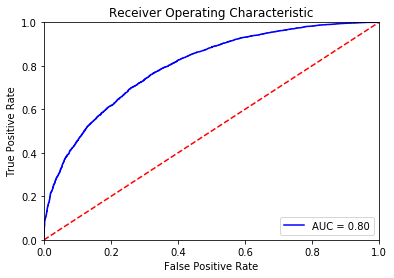

In [79]:
#plotting the ROC curve 
probs = model.predict_proba(X_important_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can see that the AUC score for this model is 0.8 which is good. AUC scores have a minimum of 0.5 which means the classifier is predicting at random and a score of 1 represents a perfect classifier. We want our model to be as close as possible to the top left corner of the graph. This is because of the reason that we want the true positive rate to increase while the false positive rate is at a minimum. In the ideal scenario, the ROC curve touches the top left corner of the graph which means that the we have a true positive rate of 1 when the false positive rate is 0 i.e. both the classes are perfectly seperatable. We can also adjust our threshold to reduce the number of false positives or negatives according to our needs.

##### Model 2: Logistic Regression

In [81]:
logistic_regression = LogisticRegression(random_state =5, solver='sag')
logistic_regression.fit(X_important_train,y_train)
y_pred = logistic_regression.predict(X_important_test)
print(accuracy_score(y_test,y_pred))

0.7116385212231857


Initially, when we ran the logistic regression baseline model using all 1000 features, we got a testing accuracy of nearly 79%. However, once the number of features were reduced to 100, logistic regression performs slightly worse than before. This may be due to the fact that the features selected by the random forests classifier were not good enough for the logistic regression classifier. First I tried tuning the hyperparameters for the model using the features that were selected by the random forests classifier. We observe that there is a minimal increase in accuracy. 

In [82]:
#Logistic Regression Model hyperparameter tuning
logistic_regression = LogisticRegression(random_state =5)
parameters =  {'penalty' : ['l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['sag']}
classifier1 = GridSearchCV(logistic_regression,parameters,cv = 5)
classifier1.fit(X_important_train,y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=5, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2'], 'C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]), 'solver': ['sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [83]:
classifier1.best_params_

{'C': 0.0006951927961775605, 'penalty': 'l2', 'solver': 'sag'}

In [84]:
accuracy_score(y_test,classifier1.predict(X_important_test))

0.713555454130534

Even after tuning the logistic regression model with the features selected from the random forests classifier, there is very little improvement in accuracy. As the improvement was minimal, I tried feature selection for logistic regression using Recursive Feature Elimination.

#### Feature Selection using Recursive Feature Selection for Logistic Regression

In [85]:
### Selecting top 100 features using RFE for logistic regression
lr = LogisticRegression ( random_state = 15, solver ='sag')
selector = RFE(lr, 100, step=100)
selector = selector.fit(X_train_std, y_train)
X_tr = selector.transform(X_train_std)
X_te = selector.transform(X_test_std)
logistic_regression = LogisticRegression(random_state =5, solver='sag')
logistic_regression.fit(X_tr,y_train)
y_pred = logistic_regression.predict(X_te)
print(accuracy_score(y_test,y_pred))

0.7248744865358284


As we can see, selecting top 100 features using RFE improves the accuracy from 71% to 72.5%. Using this method, I was able to find the optimal number of features required to learn the model well with the help of the Recursive feature selection method.

In [86]:
#finding the appropiate number of features
acc_test=[]
acc_train=[]
for i in range(100,700,100):
    lr = LogisticRegression ( random_state = 15, solver ='sag')
    selector = RFE(lr,i, step=100)
    selector = selector.fit(X_train_std, y_train)
    X_tr = selector.transform(X_train_std)
    X_te = selector.transform(X_test_std)
    important = LogisticRegression(random_state =5, solver='sag')
    important.fit(X_tr, y_train)
    acc_test.append(accuracy_score(y_test,important.predict(X_te)))
    acc_train.append(accuracy_score(y_train,important.predict(X_tr)))

Text(0.5,1,'Recusive Feature Elimination')

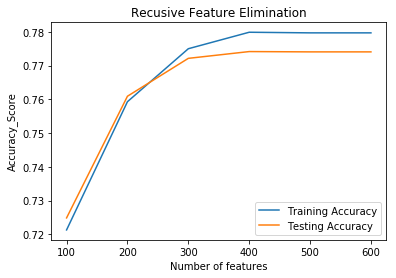

In [87]:
#plotting the graph
plt.plot(range(100,700,100),acc_train,label = 'Training Accuracy')
plt.plot(range(100,700,100),acc_test, label = 'Testing Accuracy')
plt.xlabel('Number of features')
plt.ylabel('Accuracy_Score')
plt.legend(loc='lower right')
plt.title('Recusive Feature Elimination')

We can see that once the number of features reaches 300, the increase in the accuracy per feature does not make a difference. Therefore, I have used 300 features for the Logistic Regression Classifier.

In [88]:
#training a logistic regression model with 300 features
lr = LogisticRegression ( random_state = 15, solver ='sag')
selector = RFE(lr,300, step=100)
selector = selector.fit(X_train_std, y_train)
X_important_train = selector.transform(X_train_std)
X_important_test = selector.transform(X_test_std)

#### K-fold Cross Validation

In [93]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 5, random_state = 420)
auc_scores = []
accuracy_scores = []
f1_scores = []

fold = 1
for train_idx, valid_idx in cv.split(X_important_train, y_train):
    xtrain, xvalid = X_important_train[train_idx], X_important_train[valid_idx]
    ytrain, yvalid = y_train[train_idx], y_train[valid_idx]

    model1= LogisticRegression(random_state = 1, penalty='l2',solver = 'sag')
    model1.fit(xtrain, ytrain)
    
    valid_preds=model1.predict(xvalid)
    probs = model1.predict_proba(xvalid)
    pred = probs[:,1]
    
    auc1 = roc_auc_score(yvalid, pred)
    accuracy = accuracy_score(yvalid,valid_preds)
    f1 = f1_score(yvalid,valid_preds)
    
    auc_scores.append(auc1)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    print("Fold = {}. AUC = {}. Accuracy = {}. F-1 Score = {}.".format(fold, auc1,accuracy,f1))

    fold += 1
print(' ')
print("Mean AUC Score: {}. Std Dev: {}".format(np.mean(auc_scores), np.std(auc_scores)))
print("Mean Accuracy Score: {}. Std Dev: {}".format(np.mean(accuracy_scores), np.std(accuracy_scores)))
print("Mean F-1 Score: {}. Std Dev: {}".format(np.mean(f1_scores), np.std(f1_scores)))


Fold = 1. AUC = 0.8557927056381063. Accuracy = 0.7767256132344552. F-1 Score = 0.8042021010505253.
Fold = 2. AUC = 0.8509034866637959. Accuracy = 0.772706526700137. F-1 Score = 0.8007601520304061.
Fold = 3. AUC = 0.8559341147614344. Accuracy = 0.7692834322227293. F-1 Score = 0.7943868212324589.
Fold = 4. AUC = 0.8567524823323793. Accuracy = 0.7704244637151986. F-1 Score = 0.7988804478208718.
Fold = 5. AUC = 0.8496983538512533. Accuracy = 0.7690288713910761. F-1 Score = 0.7971943887775551.
 
Mean AUC Score: 0.8538162286493938. Std Dev: 0.002913913083438026
Mean Accuracy Score: 0.7716337814527192. Std Dev: 0.0028583100105411836
Mean F-1 Score: 0.7990847821823633. Std Dev: 0.0033069621518618192


In [90]:
#Performace of testing set
model1 = LogisticRegression (random_state = 15, solver ='sag')
model1.fit(X_important_train, y_train)
y_pred = model1.predict(X_important_test)
probs = model1.predict_proba(X_important_test)
pred = probs[:,1]
print("AUC_Score : {}.".format(roc_auc_score(y_test,pred)))
print("Accuracy Score : {}.".format(accuracy_score(y_test,y_pred)))
print("F-1 Score : {}.".format(f1_score(y_test,y_pred)))

AUC_Score : 0.8540212878929596.
Accuracy Score : 0.7721588315837518.
F-1 Score : 0.799324650265316.


#### Confusion Matrix for the Classifier

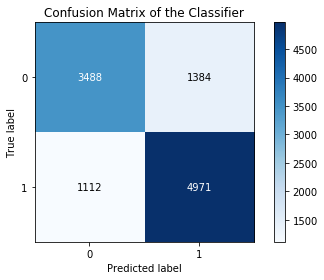

In [96]:
#printing the confusion matrix
labels = ['0','1']
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title="Confusion Matrix of the Classifier",
           ylabel='True label',
           xlabel='Predicted label')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

The confusion matrix for the logistic regression classifier is different from the Random Forest classifier even though they both have near similar f1 scores. We see that the logistic regression classifier has a large number of false negatives as compared to the random forests classifier. This is because of the default threshold used by the classifier. The threshold can be changed using the ROC curve shown below to get adjust the number of false positives and negatives according to our need.

#### ROC Curve

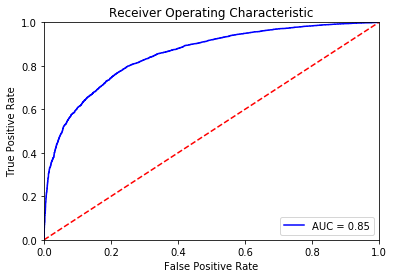

In [97]:
#plotting the ROC curve 
probs = model1.predict_proba(X_important_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC score for the logisitc regression model is 0.85 which means that it performs better than the Random Forest Classifier which had an AUC score of 0.8. 

### Concluding Remarks 

At first, data understanding was done by looking at basic statistics of each feature in the dataset. It was evident that the dataset was highly sparse and had high dimensionality. This led to the question of a class imbalance problem. A check confirmed that the problem was not present. Since the features had different ranges, standardization was required. Note that normalization was not done here as it is very sensitive to outliers. 

As a starting point, two models were built:
 - **Logistic Regression**:
    Since the number of features in the dataset were very high, the coefficients in logistic regression could not converge during training. Hence, it was important to note that feature selection was important for this data.
    
 - **Random Forest**: Two models were built here. One, with default parameters and another by specifying the max depth. Note that this was done as the former random forest classifier with default parameters overfit on the training data (as the training accuracy was 1). Therefore, the latter model was created by tuning a simple parameter, maximum depth d. This helped in overcoming the problem of overfitting. It is important to note that the optimal depth was found to be around 20.

Next, we performed feature selection. Note that the methods were implemented on top of the previous (feature selection method's)  output. The following methods were implemented:
 - **One way ANOVA F test with Benjamini Hochberg Correction**: The dimensionality of the dataset reduced from 1000 to 419 using this method.

 - **Principal Component Analysis**: This method did not help us reduce the dimensionality as each of the 419 features contributed almost equally to the explained variance of the data.
 
 - **Random Forests Classifier**: This helped reduce the dimensionality from 419 to 100.

After selecting 100 features using feature selection, I proceeded to build two models:
 - **Random Forest**: This model was tuned using GridSearchCV and a model was trained using these parameters and various metrics including AUC, F1-score, Confusion matrix and ROC curve were evaluated. This model performed close to the baseline model.
 
 - **Logistic Regression**: This model was trained on the reduced dataset consisting of only 100 features and it did not perform well as compared to the baseline model. As there was no improvement, we performed feature selection using Recursive Feature Elimination. This led to new subset of features (300 features) and the model was re-evaluated. This was done because, in any machine learning problem, if a model does not perform better than the baseline model, we update the current feature space and retrain the model. 
 
To conclude, we can say that the logistic regression performed very well on the data as compared to Random Forest Classifier model with a larger feature space of size 300 (compared to the 100). Note that it is okay to use this bigger feature space as long as computation is not a problem.

### Future Work

Due to shortage of time, I decided to spend more time on model selection and evaluation. But, other feature selection techniques that I believed might work well were Boruta and Lasso. A hyperparameter tuning method which could have been tried would be RandomSearchCV. Other machine learning model which could have been implemented on this data would be Support Vector Classifiers (SVC).